# Word Lists and Sentiment Analysis


## Note from Neal

Is this the most recent version? Some conflicts going on with data set names and descriptions. 


A traditional method of analyzing texts involes computing the proportion of words with positive connotations, the proportion of words with negative connotations, and the proportion of words that are neutral. This method is commonly referred to as sentiment analysis. The typical approach to sentiment analysis is to see how many words within a given text are also contained within a predefined list of words associated with a sentiment. So, the text "I am having a bad day" might score a "1" on a negative sentiment scale because it contains one negative word, "bad", or it might score a ".17" because one of six words in the text is negative. Some sentiment systems rank words on a scale, so that "terrific" might be a 5 while "fine" scores a 1. 

Some systems go beyond positive and negative. The proprietary LIWC program, for example, extends this to measure dozens of other word attributes, such as "tone", "analytic thinking", and "clout." More generally, these methods can be used whenever you have a list of words, and you want to count their occurrences in a set of texts. They are commonly referred to as "dictionary methods."

This lesson introduces two different dictionaries that are available in Python, AFINN, and Vader. It concludes by showing how to analyze a text corpus for occurrences of words contained in any arbitrary word list.

This lesson assumes your computer has an Anaconda Python 3.7 distribution installed.

# AFINN

[AFINN](http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010) is an English word listed developed by Finn Årup Nielsen. Words scores range from minus five (negative) to plus five (positive). The English language dictionary consists of 2,477 coded words.

If this is your first time running this notebook, you may need to install it:

```
%pip install afinn
```

In [1]:
%pip install git+https://github.com/olavski/afinn

  Cloning https://github.com/olavski/afinn to /private/var/folders/db/9wfhxd0n6mvf150g7mv79r3c0000gn/T/pip-req-build-kn_cgnh3
  Running command git clone -q https://github.com/olavski/afinn /private/var/folders/db/9wfhxd0n6mvf150g7mv79r3c0000gn/T/pip-req-build-kn_cgnh3
  Created wheel for afinn: filename=afinn-0.2.dev0-cp37-none-any.whl size=89454 sha256=559854708d7152b9ee7421a9b7efcac2cc6d4c563ecf34cb5efbf3840a975252
  Stored in directory: /private/var/folders/db/9wfhxd0n6mvf150g7mv79r3c0000gn/T/pip-ephem-wheel-cache-20ss143e/wheels/67/d2/f7/5697f49e8f94e91058bf639782d135a3a3ec778ae7051f3888
Successfully built afinn
  Found existing installation: afinn 0.1
    Uninstalling afinn-0.1:
      Successfully uninstalled afinn-0.1
Note: you may need to restart the kernel to use updated packages.


In [9]:
%matplotlib inline

from afinn import Afinn

import pandas as pd
pd.set_option('max_colwidth', 100)

After importing `Afinn`, you need to set the language, English (`en`), Danish (`da`), Swedish (`sv`),  Norwegian (`no`), french (`fr`), or emoticon (`emoticons`). 

In [10]:
afinn = Afinn(language='en')

The `score` method returns the sum of word valence scores for a text string.

In [11]:
afinn.score('Bad day.')

-3.0

In [12]:
afinn.score('Good day.')

3.0

In [13]:
afinn.score('Horrible, bad day.')

-6.0

In [14]:
afinn_no = Afinn(language='no')


In [15]:
afinn_no.score('Google translate er min beste venn!')

4.0

In all these cases, `afinn` has preprocessed the text by removing the punctuation, converting all the words to lower-case, and before analyzing it. 

<div class="alert alert-info">
<h3>Your turn</h3>
<p>Create a sentence with a score of +10 or greater and one of -10 or lower.</div>




## Behind the scenes

 Before using a sentiment dictionary, it is useful to see whether it has any face validity.  To do that, we can look at a sample of the words from the list.

After importing the pandas library, the cell below will load word list as a pandas dataframe from the tab-delimited version on Afinn's GitHub page and display a sample of 10 words.

In [18]:


afinn_wl_url = ('https://raw.githubusercontent.com'
                '/fnielsen/afinn/master/afinn/data/AFINN-111.txt')

afinn_wl_df = pd.read_csv(afinn_wl_url, 
                          header=None, # no column names
                          sep='\t',  # tab sepeated
                          names=['term', 'value']) #new column names

seed = 808 # seed for sample so results are stable
afinn_wl_df.sample(10, random_state = seed)

,term,value
1852,regret,-2
1285,indifferent,-2
681,disappoints,-2
770,doubts,-1
1644,outmaneuvered,-2
55,admit,-1
1133,haha,3
1160,haunt,-1
2435,wishing,1
21,abused,-3


We can get a sense of the distribution of word values by plotting them:

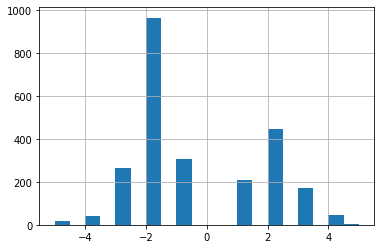

In [19]:
%matplotlib inline

afinn_wl_df['value'].hist(bins=20)

Overall, the dictionary appears to have more negative words than positive words, but the values for both positive and negative words are rarely extreme, with both two and negative two as the most common values.

## Applying the dictionary

We can use Afinn to analyze a more extensive text database.  Aashita Kesarwani put together a [corpus](https://www.kaggle.com/aashita/nyt-comments/home) of comments made to New York Times articles. I sampled 10,000 of these from April 2017 and stored them as a JSON file.


In [21]:
wine_df_full = pd.read_csv('https://raw.githubusercontent.com/nealcaren/data/master/wine_reviews_10k.csv')

The `head` method provides an overview of the dataframe.

In [ ]:
wine_df.head()

The column of interest is *commentBody.* 

To estimate the Afinn sentiment score for all of the responses in the dataframe, we can `apply` the scorer to the commentBody column to create a new column. Applying this function takes a couple of seconds.

In [ ]:
wine_df['afinn_score'] = wine_df['description'].apply(afinn.score)

`describe` gives a sense of the distribution. 

In [ ]:
wine_df['afinn_score'].describe()

It is also useful to sort by `afinn_score` to get a sense of what is in the extreme scoring comments. In this case, I subset the dataframe to display just the two relevant columns. 

In [ ]:
columns_to_display = ['description', 'afinn_score']

wine_df.sort_values(by='afinn_score')[columns_to_display].head(10)

In [ ]:
worst = wine_df.sort_values(by='afinn_score').index[0]

print(wine_df.iloc[worst]['description'])


By default, the sort is ascending, mean the lowest scoring, or most negative comments, are displayed by `head`. The comments with the highest score are shown with `tail`. 

In [ ]:
wine_df.sort_values(by='afinn_score')[columns_to_display].tail(10)

In [ ]:
best = wine_df.sort_values(by='afinn_score', ascending=False).index[0]

print(wine_df.iloc[best]['description'])



One of the drawbacks to using the raw Afinn score is the that longer texts may yield higher values simply because they contain more words. To adjust for that, we can divide the score by the number of words in the text. 

The most straightforward way to count words in a Python string is to use the `split` method, which splits a string based on white spaces, and then count the length of the resulting list.

In [ ]:
from pdtext.tf import word_count

In [ ]:
word_count('This sentence has seven words in it.')

You can employ that function on our dataframe to create a new column, `word_count` using `appply` to the text column, `commentBody`.

In [ ]:
wine_df['word_count'] = wine_df['description'].apply(word_count)

In [ ]:
wine_df['word_count'].describe()

We can divide the original score by the word count to produce `afinn_adjusted`. This isn't exactly a percentage variable, since word scores in Afinn can range from -5 to 5, but it is a useful adjustment to control for variable comment length. To make it clearer that this isn't a percent score, and to make the results more readable, the adjustment is multiplied by 100.

In [ ]:
wine_df['afinn_adjusted'] = wine_df['afinn_score'] / wine_df['word_count'] * 100

In [ ]:
wine_df['afinn_adjusted'].describe()

You can use `groupby` to see how the sentiment score varies by key characteristics.

In [ ]:
wine_df.groupby('rating')[['afinn_adjusted','afinn_score']].describe()

The above syntax maybe a little complex to decipher.
* `wine_df` is the dataframe we want to use;
* `.groupby('editorsSelection')` creates a pandas `groupby` object split by the values of `rating`;
* `['afinn_adjusted','afinn_score']` are the specific column wes want to focus on;
* `.describe()` produces descriptive statistics for each of the groups.

Pandas can also be used to create the absolute value of a variable using the `abs` method. This is useful for exploring to what extent, in this case, editors embrace or avoid comments that are extreme, either positive or negative.

<div class="alert alert-info">
<h3>Your turn</h3>
<p>Group project. Make a histogram of the sentiment of UN general election speeches.</div>



In [ ]:
# load the data

# Apply afinn.score to text column

# Histogram feature

#### Vader

A second method for sentiment analysis is [vader](https://github.com/cjhutto/vaderSentiment)(Valence Aware Dictionary and sEntiment Reasoner). According to the authors, it is, "a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media." 

As with Afinn, Vader measures both the strength and direction of sentiment. Based on the work of 10 coders, the Vader dictionary includes approximately 7,500 words, emoticons, emojis, acronyms, and commonly used slang. 

Unlike Afinn, Vader scores an entire text, not just words. Looking at the whole text allows for the algorithm to adjust for negations, such as "not", booster words, such as "remarkably". It also scores words written in all caps as more intense. Vader returns the proportion of a text that is negative, positive, and neutral, along with a combined score. 

There is a version included with nltk (`from nltk.sentiment.vader import SentimentIntensityAnalyzer`) but a more recent version can be separately installed:


```
%pip install vaderSentiment
```


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Vader requires that you set up an analyzer.

In [ ]:
analyzer = SentimentIntensityAnalyzer()

The `polarity_scores` method returns a dictionary with four items. 
* `pos`, `neu`, and `neg`  are the proportions of text that fall in each category.
* `compound` is the normalized, weighted composite score. 

In [ ]:
analyzer.polarity_scores('Horrible bad day.')

One useful feature of Vader is that it is able to look at works in context and score appropriately. 

In [ ]:
analyzer.polarity_scores("At least it isn't a horrible book.")

It also scores contemporary lingo and emojis.

In [ ]:
analyzer.polarity_scores('Today SUX!')

In [ ]:
analyzer.polarity_scores('💋')

<div class="alert alert-info">
<h3>Your turn</h3>
<p>Rerun your positive and negative sentences from before. How do they score now?</div>





Since Vader returns a dictionary (unlike Afinn which returns a single value), it is slightly more complicated to use it on an entire pandas dataframe.

First, apply the analyzer on the text column. 

In [ ]:
sentiment = wine_df['description'].apply(analyzer.polarity_scores)

Our new object `sentiment` is a series, where each item is a dictionary. This series can be unpacked into a dataframe.

In [ ]:
sentiment

In [ ]:
sentiment_df = pd.DataFrame(sentiment.tolist())

sentiment_df.head()

The new sentiment dataframe can be merged with the original dataframe.

In [ ]:
wine_df_sentiment = pd.concat([wine_df,sentiment_df], axis = 1)

In [ ]:
wine_df_sentiment.head()

If you intend to do this more than once, it can be useful to wrap the entire process into a single function that takes a dataframe and returns the datframe with the polarity columns appended. To clarify where the sentiment information comes from, the prefix `vader_` is added to each of the polarity scores.

In [ ]:
def vaderize(df, textfield):
    '''Compute the Vader polarity scores for a textfield. 
    Returns scores and original dataframe.'''

    analyzer = SentimentIntensityAnalyzer()

    print('Estimating polarity scores for %d cases.' % len(df))
    sentiment = df[textfield].apply(analyzer.polarity_scores)

    # convert to dataframe
    sdf = pd.DataFrame(sentiment.tolist()).add_prefix('vader_')

    # merge dataframes
    df_combined = pd.concat([df, sdf], axis=1)
    return df_combined

In [ ]:
df_vaderized = vaderize(wine_df, 'description')

In [ ]:
df_vaderized.head()

In [ ]:
df_vaderized['vader_compound'].plot(kind='hist')

In [ ]:
sentiment_variables = ['afinn_adjusted', 'vader_neg', 'vader_neu', 'vader_pos']

df_vaderized.groupby('rating')[sentiment_variables].mean()

#### Word List

Occasionally, you will have a sentiment list from a different source that you would like to use. Or, more generally, you have a word list about any subject, not just attitudes, and you want to count their occurrences in texts, such as the use of words associated with politics or hypothesis testing. 

The final section of the lesson shows the steps for building a function that can analyze texts for the presence of words on any given list. In this case, the sample list will be words associated with men that were assembled by [Danielle Sucher](https://github.com/DanielleSucher/Jailbreak-the-Patriarchy). 

The list is stored as a csv file. Pandas can be used to read the word list and turn it into a Python list.

In [ ]:

male_csv_location = 'https://raw.githubusercontent.com/nealcaren/KULeuvenBigData/master/notebooks/data/male_words.csv'


male_words_df = pd.read_csv(male_csv_location)

male_words_df.sample(10)

In [ ]:
male_words_list = male_words_df['term'].values

The function that looks for cooccurences has two parts. A preliminary helper function transforms the original text string into a list of lower case words stripping out any punctuation. 

In [ ]:
def text_to_words(text):
    '''Transform a string to a list of words,
    removing all punctuation.'''
    text = text.lower()

    p = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    text = ''.join([ch for ch in text if ch not in p])

    return text.split()

In [ ]:
text_to_words('Make this lower case and remove! All? Punctuation.')

The main function takes two arguments, the text and the word list. First, the text string is transformed to a list using `text_to_words`. Second, a new list `intersection` is created which contains only those elements from the text list that are in the word list. Finally, the function returns the length of the intersection. 

In [ ]:
def count_occurences(text, word_list):
    '''Count occurences of words from a list in a text string.'''
    text_list = text_to_words(text)

    intersection = [w for w in text_list if w in word_list]

    return len(intersection)

In [ ]:
count_occurences('He went to the store.', male_words_list)

The function can now be applied on the Times dataframe to count ocurrences of male words in the comments. Since the function takes a second arguement, the word list, this is passed to the `apply` method as a tuple.

In [ ]:
un_df['male_words'] = un_df['text'].apply(count_occurences, 
                                                   args=(male_words_list, ))